# Player Tracking System Comparison

This notebook compares 3 different player tracking systems:
- Eagle
- Darkmyter (using Ultralytics YOLO)
- Ultralytics YOLO 11 + Bytetrack
- Ultralytics YOLO 11 + Botsort

**Important**: Run cells in order from top to bottom!

In [3]:
# Cell 1: Setup directories and utilities

from pathlib import Path
import os

BASE_DIR = Path("/content")
REPOS_DIR = BASE_DIR / "repositories"
VIDEOS_DIR = BASE_DIR / "videos"
CLIPS_DIR = BASE_DIR / "clips"
OUTPUT_DIR = BASE_DIR / "output"

for d in [REPOS_DIR, VIDEOS_DIR, CLIPS_DIR, OUTPUT_DIR]:
    d.mkdir(parents=True, exist_ok=True)

def print_status(msg, status="INFO"):
    """Print colored status messages"""
    colors = {
        "INFO": "\033[94m",
        "SUCCESS": "\033[92m",
        "WARNING": "\033[93m",
        "ERROR": "\033[91m",
        "RESET": "\033[0m"
    }
    print(f"{colors.get(status, '')}[{status}] {msg}{colors['RESET']}")

print_status("Directory structure created", "SUCCESS")
print(f"Working directory: {BASE_DIR}")

[SUCCESS] Directory structure created
Working directory: /content


In [4]:
# Cell 2: Clone all repositories

import subprocess

REPOSITORIES = {
    "eagle": "https://github.com/nreHieW/Eagle.git",
    "darkmyter": "https://github.com/Darkmyter/Football-Players-Tracking.git",
}

print_status("Cloning repositories...", "INFO")

for name, url in REPOSITORIES.items():
    repo_path = REPOS_DIR / name

    if repo_path.exists():
        print_status(f"{name}: Already exists, skipping", "WARNING")
        continue

    try:
        print_status(f"{name}: Cloning...", "INFO")
        result = subprocess.run(
            ["git", "clone", url, str(repo_path)],
            capture_output=True,
            text=True,
            timeout=300
        )

        if result.returncode == 0:
            print_status(f"{name}: Cloned successfully", "SUCCESS")
        else:
            print_status(f"{name}: Clone failed - {result.stderr[:100]}", "ERROR")

    except Exception as e:
        print_status(f"{name}: Clone failed - {str(e)}", "ERROR")

print_status("Repository cloning complete", "SUCCESS")

[INFO] Cloning repositories...
[INFO] eagle: Cloning...
[SUCCESS] eagle: Cloned successfully
[INFO] darkmyter: Cloning...
[SUCCESS] darkmyter: Cloned successfully
[SUCCESS] Repository cloning complete


In [5]:
# Cell 3: Install dependencies

print_status("Installing dependencies...", "INFO")

!pip install -q torch torchvision torchaudio tracklab
!pip install -q opencv-python numpy scipy pandas scikit-learn matplotlib
!pip install -q ultralytics supervision
!pip install -q gdown Pillow tqdm requests

print_status("Dependencies installed", "SUCCESS")

[INFO] Installing dependencies...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 12.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.0/180.0 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 335.4/335.4 kB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 73.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 827.9/827.9 kB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 831.6/831.6 kB 55.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.3/48.3 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.5/159.5 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.9/86.9 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1

In [6]:
from ultralytics import YOLO
model = YOLO("yolo11m.pt")
print("Loaded weights from:", getattr(model, "ckpt_path", "unknown path"))

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Loaded weights from: yolo11m.pt


In [7]:
# Cell 4: Download videos from Google Drive

!pip install -q gdown

import gdown
from pathlib import Path

# Shared folder ID
FOLDER_ID = "1Cs4kTX6GYwfcpKyDZdqRKBezz49wT7_N"

print_status("Downloading videos from shared folder...", "INFO")

try:
    gdown.download_folder(
        id=FOLDER_ID,
        output=str(VIDEOS_DIR),
        quiet=False,
        use_cookies=False
    )

    # List downloaded videos
    video_extensions = ['.mp4', '.avi', '.mov', '.mkv', '.MP4', '.AVI', '.MOV', '.MKV']
    available_videos = []

    for ext in video_extensions:
        available_videos.extend(list(VIDEOS_DIR.glob(f"*{ext}")))

    if not available_videos:
        print_status("No video files found", "ERROR")
    else:
        print(f"DOWNLOADED {len(available_videos)} VIDEO(S)")


        for idx, video in enumerate(available_videos, 1):
            size_mb = video.stat().st_size / (1024 * 1024)
            print(f"{idx}. {video.name} ({size_mb:.1f} MB)")


        print("Enter video selection:")
        print("  - Leave blank to process ALL videos")
        print("  - Enter a number (e.g., '1')")
        print("  - Enter comma-separated numbers (e.g., '1,2')")

        selection = input("\nYour choice: ").strip()

        VIDEO_PATHS = []

        if not selection:
            VIDEO_PATHS = available_videos
            print_status(f"Selected ALL {len(VIDEO_PATHS)} videos", "SUCCESS")
        elif selection.isdigit():
            idx = int(selection)
            if 1 <= idx <= len(available_videos):
                VIDEO_PATHS = [available_videos[idx - 1]]
                print_status(f"Selected: {VIDEO_PATHS[0].name}", "SUCCESS")
        elif ',' in selection:
            try:
                indices = [int(x.strip()) for x in selection.split(',')]
                for idx in indices:
                    if 1 <= idx <= len(available_videos):
                        VIDEO_PATHS.append(available_videos[idx - 1])
                print_status(f"Selected {len(VIDEO_PATHS)} videos", "SUCCESS")
            except ValueError:
                print_status("Invalid input", "ERROR")

        if not VIDEO_PATHS:
            print_status("No videos selected", "ERROR")

except Exception as e:
    print_status(f"Download failed: {str(e)}", "ERROR")
    print("\nNote: Make sure the folder is set to 'Anyone with the link can view'")

[INFO] Downloading videos from shared folder...


Retrieving folder contents


Processing file 1uXckJCK4pVPfoRvJWaZmtM_uH6pFQogf FULL MATCH  Belgium 1-2 Italy  VIP Tactical Camera 720.mp4
Processing file 1RvqkxASOD23jfigqSgSgGja5_NGZReO4 FULL MATCH  Brazil v Mexico  World Cup 2018 720p.mp4
Processing file 1urwKF6wjitkREymiNi9O3jCLLIysTp6F FULL MATCH  Croatia 1-1 Czechia  VIP Tactical Camera 720p.mp4


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1uXckJCK4pVPfoRvJWaZmtM_uH6pFQogf
From (redirected): https://drive.google.com/uc?id=1uXckJCK4pVPfoRvJWaZmtM_uH6pFQogf&confirm=t&uuid=99a1455e-5394-440a-9def-e546145a0a3f
To: /content/videos/FULL MATCH  Belgium 1-2 Italy  VIP Tactical Camera 720.mp4
100%|██████████| 1.68G/1.68G [00:17<00:00, 94.1MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1RvqkxASOD23jfigqSgSgGja5_NGZReO4
From (redirected): https://drive.google.com/uc?id=1RvqkxASOD23jfigqSgSgGja5_NGZReO4&confirm=t&uuid=fe88b98e-7eb9-4510-b9fc-3974a9b31a85
To: /content/videos/FULL MATCH  Brazil v Mexico  World Cup 2018 720p.mp4
100%|██████████| 1.92G/1.92G [00:16<00:00, 114MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1urwKF6wjitkREymiNi9O3jCLLIysTp6F
From (redirected): https://drive.google.com/uc?id=1urwKF6wjitkREymiNi9O3jCL

DOWNLOADED 3 VIDEO(S)
1. FULL MATCH  Brazil v Mexico  World Cup 2018 720p.mp4 (1832.4 MB)
2. FULL MATCH  Belgium 1-2 Italy  VIP Tactical Camera 720.mp4 (1604.1 MB)
3. FULL MATCH  Croatia 1-1 Czechia  VIP Tactical Camera 720p.mp4 (1260.8 MB)
Enter video selection:
  - Leave blank to process ALL videos
  - Enter a number (e.g., '1')
  - Enter comma-separated numbers (e.g., '1,2')

Your choice: 2
[SUCCESS] Selected: FULL MATCH  Belgium 1-2 Italy  VIP Tactical Camera 720.mp4


In [8]:
# Cell 5: Extract clips

import cv2

CLIP_DURATION = 60
ALL_CLIPS = {}

for VIDEO_PATH in VIDEO_PATHS:
    VIDEO_NAME = VIDEO_PATH.stem


    print(f"PROCESSING: {VIDEO_NAME}\n")


    cap = cv2.VideoCapture(str(VIDEO_PATH))
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = total_frames / fps
    cap.release()

    print(f"Duration: {duration:.1f}s | FPS: {fps:.1f} | Frames: {total_frames}")

    if duration < CLIP_DURATION * 3:
        if duration < CLIP_DURATION:
            CLIPS = [(0, duration, "full")]
        else:
            CLIPS = [(0, CLIP_DURATION, "start"), (max(duration - CLIP_DURATION, 0), CLIP_DURATION, "end")]
    else:
        CLIPS = [
            (0, CLIP_DURATION, "start"),
            ((duration - CLIP_DURATION) / 2, CLIP_DURATION, "middle"),
            (duration - CLIP_DURATION, CLIP_DURATION, "end")
        ]

    CLIP_PATHS = {}

    for start_time, clip_dur, position in CLIPS:
        clip_name = f"{VIDEO_NAME}_{position}.mp4"
        clip_path = CLIPS_DIR / clip_name

        cmd = ["ffmpeg", "-i", str(VIDEO_PATH), "-ss", str(start_time), "-t", str(clip_dur),
               "-c", "copy", str(clip_path), "-y", "-loglevel", "error"]

        result = subprocess.run(cmd, capture_output=True)

        if result.returncode == 0 and clip_path.exists():
            CLIP_PATHS[position] = clip_path
            print_status(f"Clip '{position}' extracted", "SUCCESS")

    ALL_CLIPS[VIDEO_NAME] = CLIP_PATHS

print(f"\nTotal: {sum(len(clips) for clips in ALL_CLIPS.values())} clips from {len(VIDEO_PATHS)} video(s)")

PROCESSING: FULL MATCH  Belgium 1-2 Italy  VIP Tactical Camera 720

Duration: 6152.3s | FPS: 25.0 | Frames: 153807
[SUCCESS] Clip 'start' extracted
[SUCCESS] Clip 'middle' extracted
[SUCCESS] Clip 'end' extracted

Total: 3 clips from 1 video(s)


In [16]:

# Cell: Setup Eagle with Python 3.13

print_status("Setting up Eagle with Python 3.13...", "INFO")

eagle_dir = REPOS_DIR / "eagle"

# Install Python 3.13 (Eagle's required version)
print_status("Installing Python 3.13...", "INFO")
!apt-get update -qq
!apt-get install -y software-properties-common
!add-apt-repository -y ppa:deadsnakes/ppa
!apt-get update -qq
!apt-get install -y python3.13 python3.13-venv python3.13-dev python3.13-distutils

# Install pip for Python 3.13
!curl -sS https://bootstrap.pypa.io/get-pip.py | python3.13

# Install uv if not already installed
print_status("Installing uv...", "INFO")
!curl -LsSf https://astral.sh/uv/install.sh | sh

# Add uv to PATH
import os
os.environ['PATH'] = f"/root/.local/bin:{os.environ['PATH']}"

# Create Eagle environment with Python 3.13
os.chdir(eagle_dir)
print_status("Creating Eagle environment with Python 3.13...", "INFO")
!uv venv --python python3.13
!uv sync

# Download model weights
print_status("Downloading Eagle model weights...", "INFO")
models_dir = eagle_dir / "eagle" / "models"
if models_dir.exists():
    os.chdir(models_dir)
    !bash get_weights.sh
    os.chdir(eagle_dir)
    print_status("Eagle weights downloaded", "SUCCESS")
else:
    print_status("Eagle models directory not found", "ERROR")

# Create Eagle wrapper that uses Python 3.13

eagle_wrapper = eagle_dir / "run_eagle.py"
eagle_wrapper.write_text('''
#!/usr/bin/env python3
"""
Clean Eagle wrapper that produces a single output file
Consolidates Eagle's multiple outputs into the format expected by the evaluation pipeline
"""

import argparse
import json
import subprocess
import sys
import os
from pathlib import Path
import time


def consolidate_eagle_output(eagle_output_dir, output_format="tracking"):
    """
    Consolidate Eagle's output into a single JSON file

    Args:
        eagle_output_dir: Path to Eagle's output directory
        output_format: "tracking" for standard format, "raw" for Eagle's native format

    Returns:
        Consolidated data dictionary
    """
    # Look for raw_coordinates folder
    coords_dir = eagle_output_dir / "raw_coordinates"
    if not coords_dir.exists():
        coords_dir = eagle_output_dir

    # Find the main coordinates file
    raw_coords_file = coords_dir / "raw_coordinates.json"
    raw_data_file = coords_dir / "raw_data.json"
    processed_file = coords_dir / "processed_data.json"

    # Try different file options in order of preference
    data = None
    source_file = None

    for file_path in [raw_coords_file, processed_file, raw_data_file]:
        if file_path.exists():
            with open(file_path, 'r') as f:
                data = json.load(f)
            source_file = file_path
            print(f"[Eagle] Using {file_path.name} as source", file=sys.stderr)
            break

    if data is None:
        # Try to find any JSON file
        json_files = list(coords_dir.glob("*.json"))
        if json_files:
            with open(json_files[0], 'r') as f:
                data = json.load(f)
            source_file = json_files[0]
            print(f"[Eagle] Using {json_files[0].name} as source", file=sys.stderr)

    if data is None:
        print("[Eagle] No output files found", file=sys.stderr)
        return []

    # Convert to standard tracking format if requested
    if output_format == "tracking":
        return convert_to_tracking_format(data, source_file)
    else:
        return data


def convert_to_tracking_format(eagle_data, source_file):
    """
    Convert Eagle's format to standard tracking format
    [{"frame_id": N, "track_id": M, "bbox": [x1,y1,x2,y2], "score": S, "class_id": C}, ...]
    """
    tracking_data = []

    # Handle different Eagle output formats
    if isinstance(eagle_data, dict) and all(key.isdigit() for key in eagle_data.keys()):
        # Format: {"0": {...}, "1": {...}, ...} - raw_coordinates.json format
        for frame_str, frame_data in eagle_data.items():
            frame_id = int(frame_str)

            if 'Coordinates' in frame_data:
                coords = frame_data['Coordinates']

                # Process players
                for player_id, player_data in coords.get('Player', {}).items():
                    if 'BBox' in player_data:
                        tracking_data.append({
                            'frame_id': frame_id,
                            'track_id': int(player_id),
                            'bbox': player_data['BBox'],
                            'score': player_data.get('Confidence', 1.0),
                            'class_id': 0  # Player
                        })

                # Process goalkeepers
                for gk_id, gk_data in coords.get('Goalkeeper', {}).items():
                    if 'BBox' in gk_data:
                        tracking_data.append({
                            'frame_id': frame_id,
                            'track_id': int(gk_id),
                            'bbox': gk_data['BBox'],
                            'score': gk_data.get('Confidence', 1.0),
                            'class_id': 1  # Goalkeeper
                        })

    elif isinstance(eagle_data, list):
        # Format: [{...}, {...}, ...] - raw_data.json format
        for frame_id, frame_data in enumerate(eagle_data):
            # Process player entries
            for key in frame_data:
                if key.startswith('Player_') and '_video' in key:
                    player_id = int(key.replace('Player_', '').replace('_video', ''))
                    coords = frame_data.get(key)

                    if coords is not None:
                        # Convert center point to bounding box
                        cx, cy = coords
                        # Estimate bbox (can be adjusted based on typical player size)
                        half_width, half_height = 10, 20

                        tracking_data.append({
                            'frame_id': frame_id,
                            'track_id': player_id,
                            'bbox': [cx - half_width, cy - half_height,
                                   cx + half_width, cy + half_height],
                            'score': 1.0,
                            'class_id': 0  # Player
                        })

                elif key.startswith('Goalkeeper_') and '_video' in key:
                    gk_id = int(key.replace('Goalkeeper_', '').replace('_video', ''))
                    coords = frame_data.get(key)

                    if coords is not None:
                        cx, cy = coords
                        half_width, half_height = 10, 20

                        tracking_data.append({
                            'frame_id': frame_id,
                            'track_id': gk_id,
                            'bbox': [cx - half_width, cy - half_height,
                                   cx + half_width, cy + half_height],
                            'score': 1.0,
                            'class_id': 1  # Goalkeeper
                        })

    return tracking_data


def main():
    parser = argparse.ArgumentParser(description='Eagle wrapper for unified output')
    parser.add_argument('--video', required=True, help='Path to input video')
    parser.add_argument('--output', required=True, help='Path to output JSON file')
    parser.add_argument('--fps', default=20, type=int, help='FPS to process (default: 20)')
    parser.add_argument('--format', choices=['tracking', 'raw'], default='raw',
                       help='Output format: tracking (standard) or raw (Eagle native)')
    args = parser.parse_args()

    video_path = Path(args.video)
    output_path = Path(args.output)

    if not video_path.exists():
        print(f"Error: Video not found: {video_path}", file=sys.stderr)
        sys.exit(1)

    # Ensure output directory exists
    output_path.parent.mkdir(parents=True, exist_ok=True)

    # Set up environment
    env = os.environ.copy()
    env["CUDA_VISIBLE_DEVICES"] = "0"

    # Run Eagle
    cmd = [
        "uv", "run", "--python", "python3.13",
        "main.py",
        "--video_path", str(video_path),
        "--fps", str(args.fps),
    ]

    print(f"[Eagle] Processing {video_path.name} at {args.fps} FPS...", file=sys.stderr)
    start = time.time()

    eagle_dir = Path(__file__).parent
    result = subprocess.run(
        cmd,
        capture_output=True,
        text=True,
        cwd=eagle_dir,
        timeout=600,  # 10 minute timeout
        env=env,
    )

    elapsed = time.time() - start
    print(f"[Eagle] Processing took {elapsed:.1f}s", file=sys.stderr)

    if result.returncode != 0:
        print(f"[Eagle] Warning: Process returned {result.returncode}", file=sys.stderr)
        if result.stderr:
            print(f"[Eagle] Stderr: {result.stderr[:500]}", file=sys.stderr)

    # Find Eagle's output directory
    video_stem = video_path.stem
    eagle_output_base = eagle_dir / "output"
    eagle_output_dir = eagle_output_base / video_stem

    if not eagle_output_dir.exists():
        # Try to find directory with video name in it
        for d in eagle_output_base.iterdir():
            if d.is_dir() and video_stem in d.name:
                eagle_output_dir = d
                break

    if not eagle_output_dir.exists():
        print(f"[Eagle] Error: Could not find output directory for {video_stem}", file=sys.stderr)
        # Write empty output
        with open(output_path, 'w') as f:
            json.dump([], f)
        sys.exit(1)

    # Consolidate Eagle output into single file
    print(f"[Eagle] Consolidating output from {eagle_output_dir}", file=sys.stderr)
    consolidated_data = consolidate_eagle_output(eagle_output_dir, args.format)

    # Write consolidated output
    with open(output_path, 'w') as f:
        json.dump(consolidated_data, f, indent=2)

    # Report statistics
    if isinstance(consolidated_data, list):
        if consolidated_data and 'frame_id' in consolidated_data[0]:
            # Tracking format
            frame_ids = set(d['frame_id'] for d in consolidated_data)
            track_ids = set(d['track_id'] for d in consolidated_data)
            print(f"[Eagle] Output: {len(consolidated_data)} detections", file=sys.stderr)
            print(f"[Eagle] Frames: {len(frame_ids)} ({min(frame_ids)}-{max(frame_ids)})", file=sys.stderr)
            print(f"[Eagle] Tracks: {len(track_ids)} unique IDs", file=sys.stderr)
        else:
            print(f"[Eagle] Output: {len(consolidated_data)} frames", file=sys.stderr)
    elif isinstance(consolidated_data, dict):
        print(f"[Eagle] Output: {len(consolidated_data)} frames (raw format)", file=sys.stderr)

    print(f"[Eagle] Saved to: {output_path}", file=sys.stderr)
    sys.exit(0)


if __name__ == "__main__":
    main()

''')

eagle_wrapper.chmod(0o755)
print_status("Eagle FULL capability wrapper created", "SUCCESS")

[INFO] Setting up Eagle with Python 3.13...
[INFO] Installing Python 3.13...
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
software-properties-common is already the newest version (0.99.22.9).
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.
Repository: 'deb https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu/ jammy main'
Description:
This PPA contains more recent Python versions packaged for Ubuntu.

Disclaimer: there's no guarantee of timely updates in case of security problems or other issues. If you want to use them in a security-or-otherwise-critical environment (say, on a production server), you do so at your own risk.

Update Note
Please use this repository instead of ppa:fkrull/deadsnakes.

Reporting Issues

Issues can be re

In [17]:

# Cell: Setup Darkmyter (ByteTrack + YOLO)

print_status("Setting up Darkmyter tracking...", "INFO")

import os
import subprocess
from pathlib import Path

darkmyter_dir = REPOS_DIR / "darkmyter"

# Download football-specific weights
weights_dir = darkmyter_dir / "yolov8-weights"
weights_dir.mkdir(parents=True, exist_ok=True)

custom_weights = weights_dir / "yolov8l-football-players.pt"
gdrive_id = "12dWRBsegmyGE3feTdy9LBf1eZ-hTZ9Sx"

def download_darkmyter_weights():
    print_status("Downloading Darkmyter football weights...", "INFO")
    try:
        try:
            import gdown
        except ImportError:
            subprocess.run(["pip", "install", "gdown"], check=True)
            import gdown

        url = f"https://drive.google.com/uc?id={gdrive_id}"
        gdown.download(url, str(custom_weights), quiet=False)
        print_status("Darkmyter weights downloaded", "SUCCESS")
    except Exception as e:
        print_status(f"Failed to download weights: {e}", "ERROR")

# Check if weights exist and are valid
if custom_weights.exists():
    try:
        with open(custom_weights, "rb") as f:
            header = f.read(16)
        if header.startswith(b"<"):
            print_status("Weights file is HTML, re-downloading...", "ERROR")
            custom_weights.unlink(missing_ok=True)
            download_darkmyter_weights()
        else:
            print_status("Darkmyter weights already present", "SUCCESS")
    except Exception:
        custom_weights.unlink(missing_ok=True)
        download_darkmyter_weights()
else:
    download_darkmyter_weights()

# Create corrected Darkmyter wrapper
darkmyter_wrapper = darkmyter_dir / "run_darkmyter.py"
darkmyter_wrapper.write_text('''
#!/usr/bin/env python

import argparse
import json
import sys
from pathlib import Path

try:
    from ultralytics import YOLO
    import torch
except ImportError:
    print("Error: ultralytics or torch not installed in this env", file=sys.stderr)
    sys.exit(1)


def main() -> None:
    parser = argparse.ArgumentParser(description="Darkmyter: YOLOv8 + ByteTrack (football)")
    parser.add_argument("--video", required=True, help="Path to input video")
    parser.add_argument("--output", required=True, help="Path to output JSON (full format)")
    parser.add_argument("--conf", type=float, default=0.3, help="Confidence threshold")
    parser.add_argument("--iou", type=float, default=0.5, help="IoU threshold")

    args = parser.parse_args()

    video_path = Path(args.video)
    output_path = Path(args.output)

    if not video_path.exists():
        print(f"Error: video not found: {video_path}", file=sys.stderr)
        sys.exit(1)

    repo_root = Path(__file__).resolve().parent
    custom_weights = repo_root / "yolov8-weights" / "yolov8l-football-players.pt"

    if custom_weights.exists():
        print(f"[Darkmyter] Using football-specific weights: {custom_weights}", file=sys.stderr)
        model = YOLO(str(custom_weights))
        model_name = "yolov8l-football"
        football_specific = True
    else:
        print("[Darkmyter] Football weights not found, falling back to yolov8x.pt", file=sys.stderr)
        model = YOLO("yolov8x.pt")
        model_name = "yolov8x"
        football_specific = False

    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"[Darkmyter] Device: {device}", file=sys.stderr)

    # Stream tracking results frame by frame
    results_gen = model.track(
        source=str(video_path),
        tracker="bytetrack.yaml",
        conf=args.conf,
        iou=args.iou,
        stream=True,
        device=device,
        persist=True,
        verbose=False,
        save=False,
    )

    detections = []
    total_tracks = set()
    conf_values = []
    frames_processed = 0

    for frame_idx, r in enumerate(results_gen):
        frames_processed = frame_idx + 1

        boxes = getattr(r, "boxes", None)
        if boxes is None or boxes.id is None:
            continue

        ids = boxes.id.cpu().tolist()
        xyxy = boxes.xyxy.cpu().tolist()
        scores = boxes.conf.cpu().tolist()
        if boxes.cls is not None:
            classes = boxes.cls.cpu().tolist()
        else:
            classes = [0] * len(ids)

        for tid, box, score, cls in zip(ids, xyxy, scores, classes):
            detections.append(
                {
                    "frame_id": int(frame_idx),
                    "track_id": int(tid),
                    "bbox": [float(box[0]), float(box[1]), float(box[2]), float(box[3])],
                    "score": float(score),
                    "class_id": int(cls),
                }
            )
            total_tracks.add(int(tid))
            conf_values.append(float(score))

        if frame_idx % 100 == 0:
            print(f"[Darkmyter] Processed {frame_idx} frames...", file=sys.stderr)

    stats = {
        "total_tracks": len(total_tracks),
        "frames_processed": int(frames_processed),
        "avg_confidence": (sum(conf_values) / len(conf_values)) if conf_values else 0.0,
    }

    # Create full output with all metadata
    full_output = {
        "framework": "Darkmyter",
        "model": model_name,
        "tracker": "ByteTrack",
        "features": {
            "football_specific": football_specific,
            "dual_threshold": True,
            "optimized_for": "tactical_camera",
        },
        "detections": detections,
        "statistics": stats,
    }

    # Save FULL output to the main output path
    output_path.parent.mkdir(parents=True, exist_ok=True)
    with output_path.open("w") as f:
        json.dump(full_output, f, indent=2)

    print(f"[Darkmyter] Total detections: {len(detections)}", file=sys.stderr)
    print(f"[Darkmyter] Unique tracks: {stats['total_tracks']}", file=sys.stderr)
    print(f"[Darkmyter] Frames processed: {stats['frames_processed']}", file=sys.stderr)
    print(f"[Darkmyter] Avg confidence: {stats['avg_confidence']:.3f}", file=sys.stderr)
    print(f"[Darkmyter] Full output saved to: {output_path}", file=sys.stderr)


if __name__ == "__main__":
    main()

''')

darkmyter_wrapper.chmod(0o755)
print_status("Darkmyter wrapper created", "SUCCESS")

[INFO] Setting up Darkmyter tracking...
[SUCCESS] Darkmyter weights already present
[SUCCESS] Darkmyter wrapper created


In [11]:
import textwrap
from pathlib import Path
import yaml
import ultralytics

REPOS_DIR = Path("/content/repositories")
ultra_dir = REPOS_DIR / "ultra_trackers"
ultra_dir.mkdir(parents=True, exist_ok=True)


# 1) Runner script: choose custom configs for bytetrack + botsort
runner_script = ultra_dir / "run_ultra_yolo_tracker.py"
runner_script.write_text(textwrap.dedent("""\
    #!/usr/bin/env python
    \"\"\"Run Ultralytics YOLO (v5 / v8 / v11 weights) with a chosen tracker and dump JSON tracks.

    Usage:
      python run_ultra_yolo_tracker.py \\
          --video input.mp4 \\
          --output output.json \\
          --weights yolo11m.pt \\
          --tracker botsort
    \"\"\"

    import argparse
    import json
    from pathlib import Path
    from ultralytics import YOLO
    import yaml

    def main():
        parser = argparse.ArgumentParser(description="YOLO + tracker to JSON")
        parser.add_argument("--video", required=True, help="Path to input video")
        parser.add_argument("--output", required=True, help="Path to output JSON")
        parser.add_argument(
            "--weights",
            default="yolo11m.pt",
            help="YOLO weights (e.g., yolov5s.pt, yolov8n.pt, yolo11m.pt, ...)",
        )
        parser.add_argument(
            "--tracker",
            default="botsort",
            choices=["botsort", "bytetrack", "deepsort"],
            help="Which tracker to use",
        )
        parser.add_argument("--conf", type=float, default=0.3,
                    help="Confidence threshold (detector)")
        parser.add_argument("--iou", type=float, default=0.4,
                    help="IOU threshold for NMS (lower = keep more boxes)")
        parser.add_argument("--imgsz", type=int, default=1280,
                    help="Image size for inference")
        parser.add_argument("--max-det", type=int, default=300,
                    help="Maximum detections per image")

        args = parser.parse_args()

        video_path = Path(args.video)
        out_path = Path(args.output)

        if not video_path.exists():
            raise SystemExit(f"Video not found: {video_path}")

        # Load YOLO model
        model = YOLO(args.weights)

        # Get the script's directory for saving custom configs
        ultra_root = Path(__file__).resolve().parent

        # Try to load Ultralytics default configs first
        import ultralytics
        ultra_path = Path(ultralytics.__file__).parent
        tracker_base_path = ultra_path / "cfg" / "trackers"

        # Select the default config path
        if args.tracker == "bytetrack":
            default_cfg_path = tracker_base_path / "bytetrack.yaml"
        elif args.tracker == "botsort":
            default_cfg_path = tracker_base_path / "botsort.yaml"
        else:  # deepsort
            default_cfg_path = tracker_base_path / "deepsort.yaml"

        # Path for our custom config
        custom_cfg_path = ultra_root / f"{args.tracker}_football.yaml"

        # Load and modify the config
        if default_cfg_path.exists():
            # Load the default config
            with open(default_cfg_path, 'r') as f:
                tracker_cfg = yaml.safe_load(f)

            # Modify with football-optimized values
            if args.tracker == "bytetrack":
                tracker_cfg.update({
                    "track_high_thresh": 0.5,
                    "track_low_thresh": 0.1,
                    "new_track_thresh": 0.6,
                    "track_buffer": 30,
                    "match_thresh": 0.7,
                    "min_box_area": 100,
                    "mot20": False,
                })
            elif args.tracker == "botsort":
                tracker_cfg.update({
                    "track_high_thresh": 0.5,
                    "track_low_thresh": 0.1,
                    "new_track_thresh": 0.6,
                    "track_buffer": 30,
                    "match_thresh": 0.8,
                    "proximity_thresh": 0.5,
                    "appearance_thresh": 0.25,
                    "cmc_method": "sparseOptFlow",
                    "frame_rate": 30,
                    "lambda_": 0.985,
                    "with_reid":True
                })
            elif args.tracker == "deepsort":
                tracker_cfg.update({
                    "track_high_thresh": 0.5,
                    "track_low_thresh": 0.1,
                    "track_buffer": 30,
                    "match_thresh": 0.7,
                })

            # Save the modified config to a file
            with open(custom_cfg_path, 'w') as f:
                yaml.dump(tracker_cfg, f)

            # Use the custom config FILE PATH (not the dictionary!)
            tracker_cfg_path = str(custom_cfg_path)
        else:
            # Fallback: just use the default tracker name
            print(f"Warning: Could not find default config at {default_cfg_path}")
            print(f"Using default tracker: {args.tracker}.yaml")
            tracker_cfg_path = f"{args.tracker}.yaml"

        # Run tracking with the config FILE PATH
        results = model.track(
            source=str(video_path),
            tracker=tracker_cfg_path,  # Pass the FILE PATH, not dictionary!
            conf=args.conf,
            iou=args.iou,
            imgsz=args.imgsz,
            max_det=args.max_det,
            stream=True,
            device=0,
            save=False,
            verbose=False,
            persist=True,
            vid_stride=1,
        )

        print(f"Tracking with {args.tracker} on device: {model.device}")

        all_detections = []
        frame_idx = 0

        for r in results:
            boxes = r.boxes
            if boxes is None:
                frame_idx += 1
                continue

            ids = boxes.id
            if ids is None:
                frame_idx += 1
                continue

            xyxy = boxes.xyxy
            confs = boxes.conf
            clses = boxes.cls

            ids = ids.cpu().tolist()
            xyxy = xyxy.cpu().tolist()
            confs = confs.cpu().tolist()
            clses = clses.cpu().tolist()

            for tid, (x1, y1, x2, y2), score, c in zip(ids, xyxy, confs, clses):
                all_detections.append({
                    "frame_id": frame_idx,
                    "track_id": int(tid),
                    "bbox": [float(x1), float(y1), float(x2), float(y2)],
                    "score": float(score),
                    "class_id": int(c),
                })

            frame_idx += 1

        out_path.parent.mkdir(parents=True, exist_ok=True)
        with out_path.open("w") as f:
            json.dump(all_detections, f)

        print(f"Wrote {len(all_detections)} tracked detections to {out_path}")


    if __name__ == "__main__":
        main()
    """))

runner_script.chmod(0o755)
print_status("Created wrapper for Botsort and Bytetrack", "SUCCESS")



[SUCCESS] Created wrapper for Botsort and Bytetrack


In [18]:
# Cell: Final System Evaluation

import time
import json
import subprocess
import os
from pathlib import Path

"""SYSTEM_CONFIGS = {
      "eagle": {
        "path": REPOS_DIR / "eagle",
        "script": "run_eagle.py",
        "python": "python3.13",
    },
    "darkmyter": {
        "path": REPOS_DIR / "darkmyter",
        "script": "run_darkmyter.py",
    },
    "yolo11_botsort": {
        "path": REPOS_DIR / "ultra_trackers",
        "script": "run_ultra_yolo_tracker.py",
        "args": ["--weights", "yolo11m.pt", "--tracker", "botsort", "--conf", "0.4"],
    },
    "yolo11_bytetrack": {
        "path": REPOS_DIR / "ultra_trackers",
        "script": "run_ultra_yolo_tracker.py",
        "args": ["--weights", "yolo11m.pt", "--tracker", "bytetrack", "--conf", "0.4"],
    },
}
"""
# System configurations
SYSTEM_CONFIGS = {

    "yolo11_botsort": {
        "path": REPOS_DIR / "ultra_trackers",
        "script": "run_ultra_yolo_tracker.py",
        "args": ["--weights", "yolo11m.pt", "--tracker", "botsort", "--conf", "0.4"],
    },
    "darkmyter": {
        "path": REPOS_DIR / "darkmyter",
        "script": "run_darkmyter.py",
    },
    "eagle": {
        "path": REPOS_DIR / "eagle",
        "script": "run_eagle.py",
        "python": "python3.13",
    },
}


position_to_number = {"start": 1, "middle": 2, "end": 3, "full": 1}

def run_system_on_clip(system_name, system_config, video_name, clip_number, clip_path):
    """Run a tracking system on a clip"""

    output_dir = OUTPUT_DIR / video_name / "clips" / str(clip_number) / system_name
    output_dir.mkdir(parents=True, exist_ok=True)

    print_status(f"Running {system_name} on {video_name}/clip_{clip_number}...", "INFO")

    start_time = time.time()
    output_file = output_dir / (f"{system_name}_output.json")
    system_path = system_config.get("path", REPOS_DIR)

    # Build command as before for non-TrackLab systems
    if system_name == "eagle":
        cmd = [
            "uv", "run", "--python", system_config.get("python", "python3.13"),
            "run_eagle.py",
            "--video", str(clip_path),
            "--output", str(output_file),
        ]
    else:
        cmd = [
            "python", system_config["script"],
            "--video", str(clip_path),
            "--output", str(output_file),
        ]
        for extra in system_config.get("args", []):
            cmd.append(str(extra))

    try:
        result = subprocess.run(
            cmd,
            capture_output=True,
            text=True,
            timeout=600,
            cwd=str(system_path),
        )

        elapsed = time.time() - start_time

        if result.returncode == 0 and output_file.exists():
            try:
                with open(output_file) as f:
                    data = json.load(f)

                if isinstance(data, list):
                    num_detections = len(data)
                elif isinstance(data, dict):
                    num_detections = sum(
                        len(dets) if isinstance(dets, list) else 0
                        for dets in data.values()
                    )
                else:
                    num_detections = 0

                print_status(
                    f"{system_name}: SUCCESS - {num_detections} detections in {elapsed:.1f}s",
                    "SUCCESS"
                )
                return {
                    "success": True,
                    "time": elapsed,
                    "output": str(output_file),
                    "detections": num_detections,
                }

            except json.JSONDecodeError as e:
                print_status(f"{system_name}: Invalid JSON", "ERROR")
                return {"success": False, "time": elapsed, "error": f"Invalid JSON: {e}"}
        else:
            error_msg = result.stderr[-500:] if result.stderr else "Unknown error"
            print_status(f"{system_name}: FAILED", "ERROR")
            print(f"Error: {error_msg}")
            return {"success": False, "time": elapsed, "error": error_msg}

    except subprocess.TimeoutExpired:
        print_status(f"{system_name}: TIMEOUT", "ERROR")
        return {"success": False, "time": 600, "error": "Timeout"}

    except Exception as e:
        print_status(f"{system_name}: EXCEPTION - {str(e)}", "ERROR")
        return {"success": False, "time": time.time() - start_time, "error": str(e)}


# Main evaluation
print("\n" + "="*60)
print("STARTING EVALUATION")
print("="*60 + "\n")

all_results = {}

for video_name, clip_paths in ALL_CLIPS.items():
    print(f"\nVIDEO: {video_name}")
    print("="*40)

    video_results = {}

    for clip_position, clip_path in clip_paths.items():
        clip_number = position_to_number.get(clip_position, 1)

        print(f"\nProcessing clip {clip_number} ({clip_position})...")
        video_results[f"clip_{clip_number}"] = {}

        for system_name, system_config in SYSTEM_CONFIGS.items():
            result = run_system_on_clip(system_name, system_config, video_name, clip_number, clip_path)
            video_results[f"clip_{clip_number}"][system_name] = result

        successful = sum(1 for r in video_results[f"clip_{clip_number}"].values() if r["success"])
        total = len(video_results[f"clip_{clip_number}"])
        print(f"Clip summary: {successful}/{total} systems succeeded")

    all_results[video_name] = video_results

    summary_file = OUTPUT_DIR / video_name / "summary.json"
    with open(summary_file, "w") as f:
        json.dump(video_results, f, indent=2)

overall_summary = OUTPUT_DIR / "overall_summary.json"
with open(overall_summary, "w") as f:
    json.dump(all_results, f, indent=2)

# Final statistics
print("\n" + "="*60)
print("EVALUATION COMPLETE")
print("="*60)

system_stats = {sys: {"success": 0, "total": 0} for sys in SYSTEM_CONFIGS.keys()}

for video_results in all_results.values():
    for clip_results in video_results.values():
        for system_name, result in clip_results.items():
            system_stats[system_name]["total"] += 1
            if result["success"]:
                system_stats[system_name]["success"] += 1

print("\nSystem Success Rates:")
for system_name, stats in system_stats.items():
    if stats["total"] > 0:
        success_rate = (stats["success"] / stats["total"]) * 100
        print(f"  {system_name}: {stats['success']}/{stats['total']} ({success_rate:.1f}%)")

print(f"\nResults: {OUTPUT_DIR}")
print(f"Summary: {overall_summary}")

# Cell 8: Display results

import pandas as pd


print("RESULTS SUMMARY \n")


summary_data = []

for video_name, clips in all_results.items():
    for clip_key, systems in clips.items():
        for system_name, result in systems.items():
            summary_data.append({
                "Video": video_name,
                "Clip": clip_key,
                "System": system_name,
                "Status": "Valid" if result["success"] else "Invalid",
                "Time (s)": f"{result['time']:.1f}"
            })

df = pd.DataFrame(summary_data)
print(df.to_string(index=False))

total_runs = len(summary_data)
successful_runs = sum(1 for row in summary_data if row["Status"] == "Valid")


print(f"Success Rate: {successful_runs}/{total_runs} ({100*successful_runs/total_runs:.1f}%)\n")



STARTING EVALUATION


VIDEO: FULL MATCH  Belgium 1-2 Italy  VIP Tactical Camera 720

Processing clip 1 (start)...
[INFO] Running yolo11_botsort on FULL MATCH  Belgium 1-2 Italy  VIP Tactical Camera 720/clip_1...
[SUCCESS] yolo11_botsort: SUCCESS - 23922 detections in 112.0s
[INFO] Running yolo11_bytetrack on FULL MATCH  Belgium 1-2 Italy  VIP Tactical Camera 720/clip_1...
[SUCCESS] yolo11_bytetrack: SUCCESS - 23094 detections in 88.2s
[INFO] Running darkmyter on FULL MATCH  Belgium 1-2 Italy  VIP Tactical Camera 720/clip_1...
[SUCCESS] darkmyter: SUCCESS - 28501 detections in 49.0s
[INFO] Running eagle on FULL MATCH  Belgium 1-2 Italy  VIP Tactical Camera 720/clip_1...
[SUCCESS] eagle: SUCCESS - 0 detections in 205.2s
Clip summary: 4/4 systems succeeded

Processing clip 2 (middle)...
[INFO] Running yolo11_botsort on FULL MATCH  Belgium 1-2 Italy  VIP Tactical Camera 720/clip_2...
[SUCCESS] yolo11_botsort: SUCCESS - 25289 detections in 116.2s
[INFO] Running yolo11_bytetrack on FULL MAT

[INFO] Starting comprehensive tracking evaluation...
[INFO] Loading tracking outputs...
[INFO] Scanning directory: /content/output
[INFO] Found match: FULL MATCH  Belgium 1-2 Italy  VIP Tactical Camera 720
[INFO]   Processing clip 1...
[SUCCESS]     ✓ Eagle: 1376 frames
[SUCCESS]     ✓ Darkmyter: 1376 frames
[SUCCESS]     ✓ YOLO11-BotSort: 1376 frames
[SUCCESS]     ✓ YOLO11-ByteTrack: 1376 frames
[INFO]   Processing clip 2...
[SUCCESS]     ✓ Eagle: 1401 frames
[SUCCESS]     ✓ Darkmyter: 1401 frames
[SUCCESS]     ✓ YOLO11-BotSort: 1401 frames
[SUCCESS]     ✓ YOLO11-ByteTrack: 1401 frames
[INFO]   Processing clip 3...
[SUCCESS]     ✓ Eagle: 1443 frames
[SUCCESS]     ✓ Darkmyter: 1443 frames
[SUCCESS]     ✓ YOLO11-BotSort: 1443 frames
[SUCCESS]     ✓ YOLO11-ByteTrack: 1443 frames
[SUCCESS] Successfully loaded 12 system outputs

INDIVIDUAL SYSTEM EVALUATION

Eagle - FULL MATCH  Belgium 1-2 Italy  VIP Tactical Camera 720_clip_1:
  Frames: 1376
  Detections: 27497
  Unique tracks: 34
  Avg c

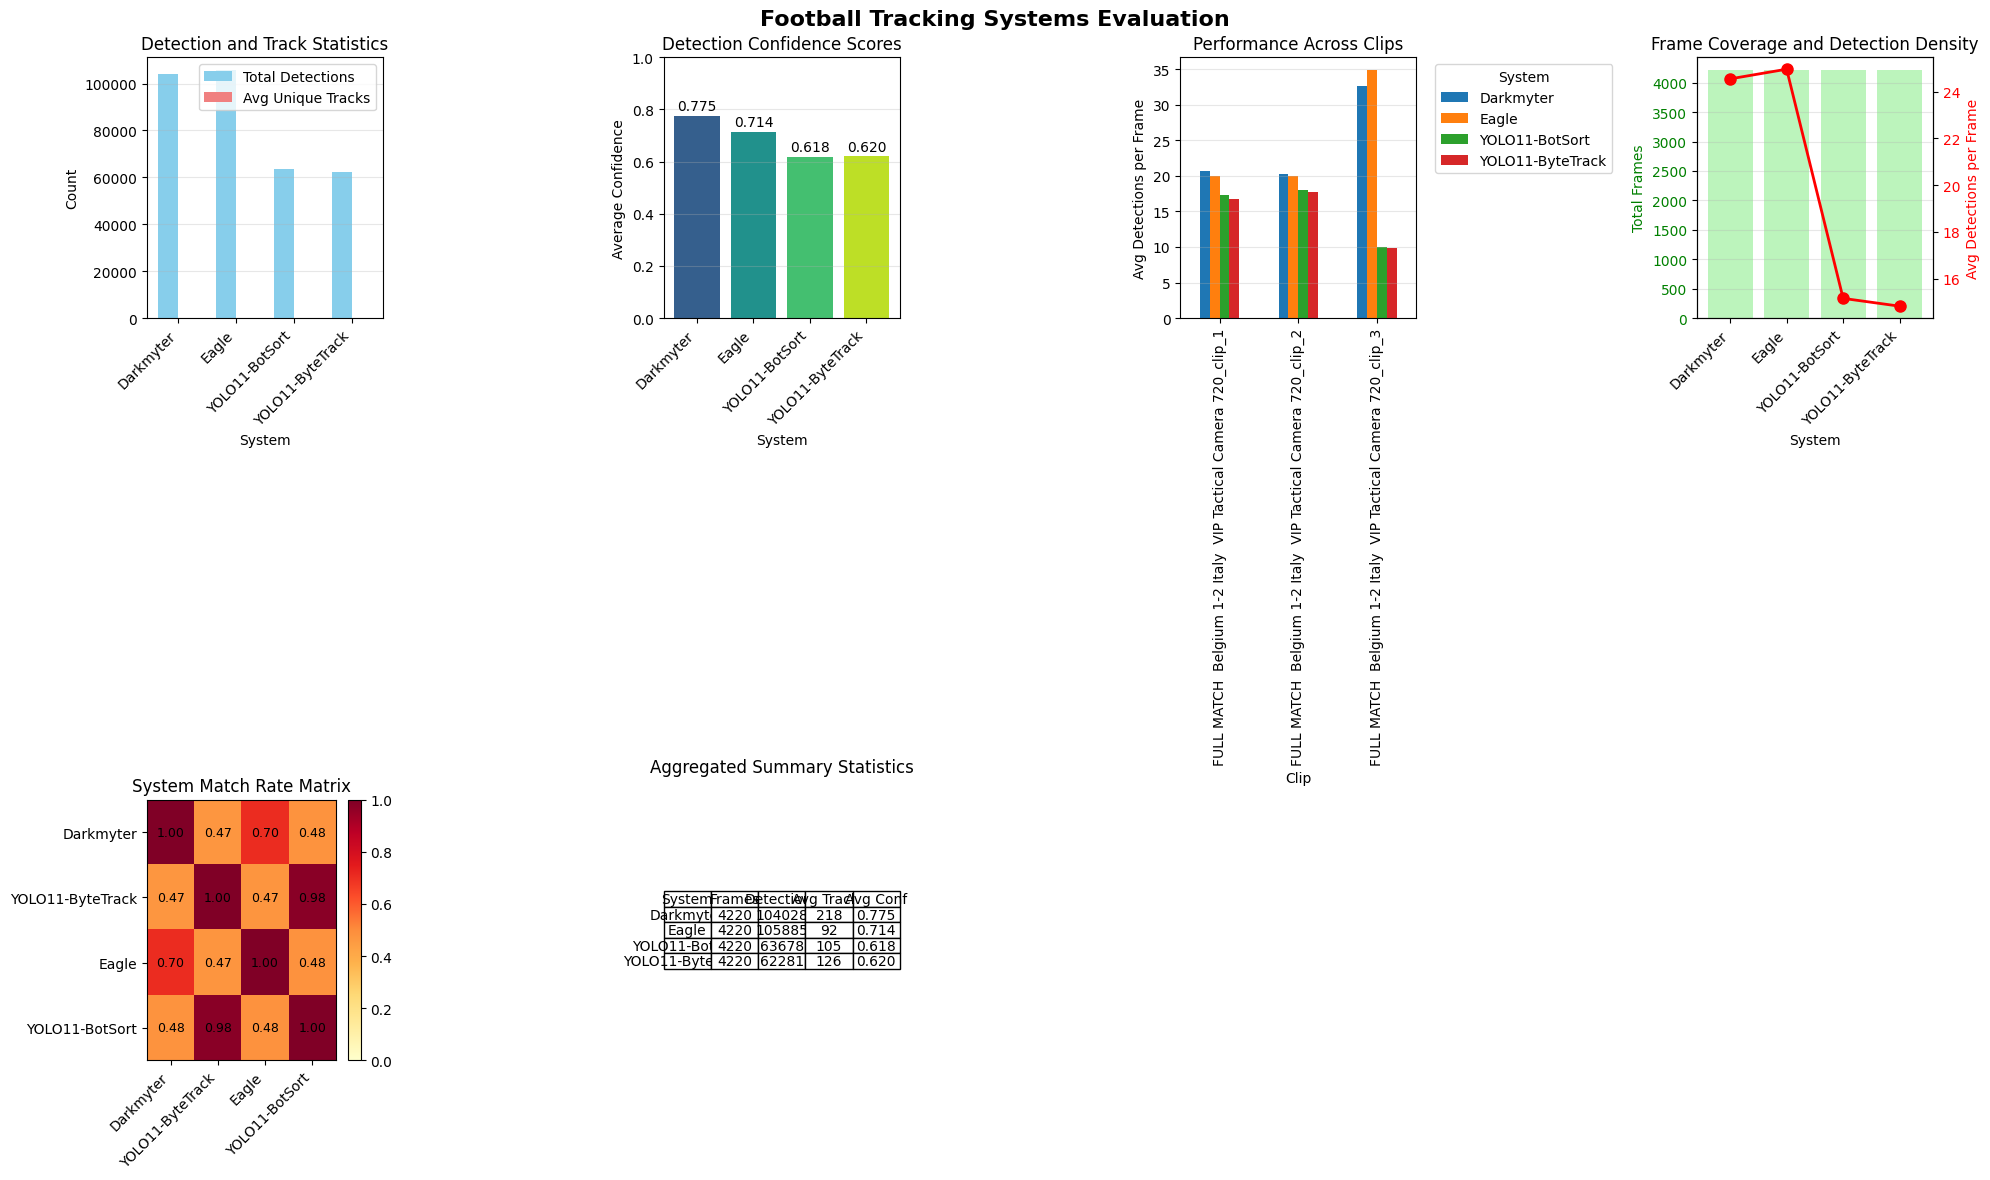

[SUCCESS] Results saved to tracking_evaluation_results.csv
[SUCCESS] Comparisons saved to tracking_comparison_results.csv

EVALUATION SUMMARY

🏆 Best confidence: Darkmyter (0.775)
🏆 Most tracks: Darkmyter (218 avg tracks)
🏆 Best continuity: YOLO11-ByteTrack (592 total fragmentations)
[SUCCESS] Evaluation complete!


In [27]:
"""
Evaluation Cell for Football Player Tracking Systems
Updated to match your exact directory structure:
- output/FULL_MATCH_NAME/clips/1/system_name/system_output.json
"""

# ============================================================================
# EVALUATION CELL - Add this to your Colab notebook
# ============================================================================

import json
import numpy as np
import pandas as pd
from pathlib import Path
from typing import Dict, List, Tuple, Optional, Any
from dataclasses import dataclass, field
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print_status("Starting comprehensive tracking evaluation...", "INFO")

# ============================================================================
# DATA STRUCTURES
# ============================================================================

@dataclass
class Detection:
    """Universal detection representation"""
    frame_id: int
    track_id: int
    bbox: List[float]  # [x1, y1, x2, y2]
    confidence: float = 1.0
    class_id: int = 0

    # Eagle-specific
    transformed_coords: Optional[Tuple[float, float]] = None
    is_goalkeeper: bool = False

    # Metadata
    source_system: str = ""
    raw_data: Dict = field(default_factory=dict)


@dataclass
class SystemData:
    """Container for system tracking data"""
    name: str
    frames: Dict[int, List[Detection]]
    metadata: Dict[str, Any]
    source_file: str
    clip_name: str = ""


# ============================================================================
# DATA LOADERS
# ============================================================================

class UniversalLoader:
    """Load tracking data from different systems"""
    @staticmethod
    def load_eagle(filepath: Path) -> SystemData:
        """Load Eagle data (handles both raw_coordinates and standard format)"""
        with open(filepath, "r") as f:
            data = json.load(f)

        from collections import defaultdict
        frames = defaultdict(list)
        metadata = {"system": "Eagle", "features": []}

        # ------------------------------------------------------------------
        # CASE 1: Eagle raw_coordinates format
        # Top-level dict with keys "0","1","2",... each containing:
        # {
        #   "Coordinates": {
        #       "Player": { id: {"BBox": [...], "Confidence": ..., "Transformed_Coordinates": [...]}, ... },
        #       "Goalkeeper": { ... }
        #   },
        #   "Keypoints": ...
        # }
        # ------------------------------------------------------------------
        if isinstance(data, dict) and data:
            all_keys = list(data.keys())
            if all(k.isdigit() for k in all_keys):
                metadata["features"] = ["field_coordinates", "goalkeeper_detection", "keypoints"]
                metadata["format"] = "raw_coordinates"

                # iterate all frames, not just one
                for frame_str in sorted(all_keys, key=lambda s: int(s)):
                    frame_data = data[frame_str]
                    frame_id = int(frame_str)

                    coords = frame_data.get("Coordinates", {})

                    # ---- Players ----
                    for player_id, player_data in coords.get("Player", {}).items():
                        if "BBox" not in player_data:
                            continue

                        tc = player_data.get("Transformed_Coordinates")
                        if isinstance(tc, (list, tuple)) and len(tc) >= 2:
                            transformed_coords = (float(tc[0]), float(tc[1]))
                        else:
                            transformed_coords = None

                        det = Detection(
                            frame_id=frame_id,
                            track_id=int(player_id),
                            bbox=player_data["BBox"],
                            confidence=player_data.get("Confidence", 1.0),
                            class_id=0,
                            transformed_coords=transformed_coords,
                            is_goalkeeper=False,
                            source_system="Eagle",
                            raw_data=player_data,
                        )
                        frames[frame_id].append(det)

                    # ---- Goalkeepers ----
                    for gk_id, gk_data in coords.get("Goalkeeper", {}).items():
                        if "BBox" not in gk_data:
                            continue

                        tc = gk_data.get("Transformed_Coordinates")
                        if isinstance(tc, (list, tuple)) and len(tc) >= 2:
                            transformed_coords = (float(tc[0]), float(tc[1]))
                        else:
                            transformed_coords = None

                        det = Detection(
                            frame_id=frame_id,
                            track_id=int(gk_id),
                            bbox=gk_data["BBox"],
                            confidence=gk_data.get("Confidence", 1.0),
                            class_id=1,
                            transformed_coords=transformed_coords,
                            is_goalkeeper=True,
                            source_system="Eagle",
                            raw_data=gk_data,
                        )
                        frames[frame_id].append(det)

                    # ---- Keypoints metadata (optional) ----
                    if "Keypoints" in frame_data:
                        metadata.setdefault("keypoints", []).append(
                            {"frame": frame_id, "points": frame_data["Keypoints"]}
                        )

        # ------------------------------------------------------------------
        # CASE 2: already in standard tracking format
        # [ { "frame_id": ..., "track_id": ..., "bbox": [...], "score": ..., "class_id": ... }, ... ]
        # ------------------------------------------------------------------
        elif isinstance(data, list):
            metadata["format"] = "standard"
            for det_dict in data:
                det = Detection(
                    frame_id=det_dict["frame_id"],
                    track_id=det_dict["track_id"],
                    bbox=det_dict["bbox"],
                    confidence=det_dict.get("score", 1.0),
                    class_id=det_dict.get("class_id", 0),
                    source_system="Eagle",
                )
                frames[det.frame_id].append(det)

        return SystemData(
            name="Eagle",
            frames=dict(frames),
            metadata=metadata,
            source_file=str(filepath),
        )
    @staticmethod
    def load_darkmyter(filepath: Path) -> SystemData:
        """Load Darkmyter data (YOLOv8 with ByteTrack)"""
        with open(filepath, 'r') as f:
            data = json.load(f)

        frames = defaultdict(list)
        metadata = {"system": "Darkmyter"}

        # Check if it's the full format with metadata
        if isinstance(data, dict) and 'framework' in data:
            metadata.update({
                "model": data.get('model', 'yolov8'),
                "tracker": data.get('tracker', 'ByteTrack'),
                "features": data.get('features', {}),
                "statistics": data.get('statistics', {})
            })
            detections = data.get('detections', [])
        else:
            # Simple list format
            detections = data if isinstance(data, list) else []

        for det_dict in detections:
            det = Detection(
                frame_id=det_dict['frame_id'],
                track_id=det_dict['track_id'],
                bbox=det_dict['bbox'],
                confidence=det_dict['score'],
                class_id=det_dict['class_id'],
                source_system="Darkmyter"
            )
            frames[det.frame_id].append(det)

        return SystemData(
            name="Darkmyter",
            frames=dict(frames),
            metadata=metadata,
            source_file=str(filepath)
        )

    @staticmethod
    def load_yolo11(filepath: Path, tracker_name: str = "YOLO11") -> SystemData:
        """Load YOLO11 data (with BotSort or ByteTrack)"""
        with open(filepath, 'r') as f:
            data = json.load(f)

        frames = defaultdict(list)
        metadata = {
            "system": tracker_name,
            "model": "YOLOv11",
            "tracker": "BotSort" if "botsort" in tracker_name.lower() else "ByteTrack"
        }

        # Handle both list and dict formats
        detections = data if isinstance(data, list) else data.get('detections', [])

        for det_dict in detections:
            det = Detection(
                frame_id=det_dict['frame_id'],
                track_id=det_dict['track_id'],
                bbox=det_dict['bbox'],
                confidence=det_dict['score'],
                class_id=det_dict['class_id'],
                source_system=tracker_name
            )
            frames[det.frame_id].append(det)

        return SystemData(
            name=tracker_name,
            frames=dict(frames),
            metadata=metadata,
            source_file=str(filepath)
        )


# ============================================================================
# EVALUATION METRICS
# ============================================================================

class TrackingEvaluator:
    """Evaluate tracking performance"""

    def __init__(self, iou_threshold: float = 0.5):
        self.iou_threshold = iou_threshold

    def calculate_iou(self, bbox1: List[float], bbox2: List[float]) -> float:
        """Calculate Intersection over Union"""
        x1_min, y1_min, x1_max, y1_max = bbox1
        x2_min, y2_min, x2_max, y2_max = bbox2

        x_inter_min = max(x1_min, x2_min)
        y_inter_min = max(y1_min, y2_min)
        x_inter_max = min(x1_max, x2_max)
        y_inter_max = min(y1_max, y2_max)

        if x_inter_max < x_inter_min or y_inter_max < y_inter_min:
            return 0.0

        inter_area = (x_inter_max - x_inter_min) * (y_inter_max - y_inter_min)
        area1 = (x1_max - x1_min) * (y1_max - y1_min)
        area2 = (x2_max - x2_min) * (y2_max - y2_min)
        union_area = area1 + area2 - inter_area

        return inter_area / union_area if union_area > 0 else 0.0

    def evaluate_system(self, system_data: SystemData) -> Dict:
        """Evaluate a single system"""
        total_detections = sum(len(dets) for dets in system_data.frames.values())
        unique_tracks = set()
        confidence_values = []

        for detections in system_data.frames.values():
            for det in detections:
                unique_tracks.add(det.track_id)
                confidence_values.append(det.confidence)

        # Track continuity analysis
        track_lifetimes = defaultdict(list)
        for frame_id, detections in system_data.frames.items():
            for det in detections:
                track_lifetimes[det.track_id].append(frame_id)

        # Calculate fragmentations
        fragmentations = 0
        for track_id, frame_list in track_lifetimes.items():
            frame_list = sorted(frame_list)
            for i in range(1, len(frame_list)):
                if frame_list[i] - frame_list[i-1] > 1:
                    fragmentations += 1

        # Eagle-specific metrics
        eagle_metrics = {}
        if system_data.name == "Eagle" and system_data.metadata.get('format') == 'raw_coordinates':
            goalkeeper_count = sum(1 for dets in system_data.frames.values()
                                 for det in dets if det.is_goalkeeper)
            with_coords = sum(1 for dets in system_data.frames.values()
                             for det in dets if det.transformed_coords)
            eagle_metrics = {
                'goalkeeper_detections': goalkeeper_count,
                'detections_with_field_coords': with_coords,
                'has_keypoints': 'keypoints' in system_data.metadata
            }

        return {
            'system': system_data.name,
            'clip': system_data.clip_name,
            'total_frames': len(system_data.frames),
            'total_detections': total_detections,
            'unique_tracks': len(unique_tracks),
            'avg_detections_per_frame': total_detections / len(system_data.frames) if system_data.frames else 0,
            'avg_confidence': np.mean(confidence_values) if confidence_values else 0,
            'std_confidence': np.std(confidence_values) if confidence_values else 0,
            'fragmentations': fragmentations,
            'avg_track_lifetime': np.mean([len(frames) for frames in track_lifetimes.values()]) if track_lifetimes else 0,
            **eagle_metrics
        }

    def compare_systems(self, sys1: SystemData, sys2: SystemData) -> Dict:
        """Compare two systems on overlapping frames"""
        common_frames = set(sys1.frames.keys()) & set(sys2.frames.keys())

        if not common_frames:
            return {
                'comparison': f"{sys1.name} vs {sys2.name}",
                'clip': sys1.clip_name,
                'common_frames': 0,
                'message': 'No overlapping frames'
            }

        matches = 0
        total_iou = 0
        sys1_only = 0
        sys2_only = 0

        for frame_id in common_frames:
            dets1 = sys1.frames[frame_id]
            dets2 = sys2.frames[frame_id]

            matched2 = set()

            for d1 in dets1:
                best_iou = 0
                best_match = None

                for i, d2 in enumerate(dets2):
                    if i in matched2:
                        continue
                    iou = self.calculate_iou(d1.bbox, d2.bbox)
                    if iou > best_iou:
                        best_iou = iou
                        best_match = i

                if best_iou >= self.iou_threshold:
                    matches += 1
                    total_iou += best_iou
                    matched2.add(best_match)
                else:
                    sys1_only += 1

            sys2_only += len(dets2) - len(matched2)

        return {
            'comparison': f"{sys1.name} vs {sys2.name}",
            'clip': sys1.clip_name,
            'common_frames': len(common_frames),
            'matched_detections': matches,
            'avg_iou': total_iou / matches if matches > 0 else 0,
            f'{sys1.name}_only': sys1_only,
            f'{sys2.name}_only': sys2_only,
            'match_rate': matches / (matches + sys1_only + sys2_only) if (matches + sys1_only + sys2_only) > 0 else 0
        }


# ============================================================================
# LOAD DATA FROM YOUR EXACT STRUCTURE
# ============================================================================

def load_tracking_outputs_from_structure(base_dir: Path):
    """
    Load tracking outputs from your directory structure:

    /content/output/
        <MATCH_NAME>/
            clips/
                1/
                    darkmyter/darkmyter_output.json
                    eagle/eagle_output.json
                    yolo11_botsort/yolo11_botsort_output.json
                    yolo11_bytetrack/yolo11_bytetrack_output.json
    """
    systems = []
    loader = UniversalLoader()

    if not base_dir.exists():
        print_status(f"Base directory does not exist: {base_dir}", "ERROR")
        return systems

    print_status(f"Scanning directory: {base_dir}", "INFO")

    # Treat *every* subdirectory of base_dir as a match directory
    for match_dir in sorted(base_dir.iterdir()):
        if not match_dir.is_dir():
            continue

        match_name = match_dir.name
        print_status(f"Found match: {match_name}", "INFO")

        clips_dir = match_dir / "clips"
        if not clips_dir.exists():
            print_status(f"  No clips directory in {match_name}", "WARNING")
            continue

        # Process each clip folder (e.g., "1", "2", ...)
        for clip_dir in sorted(clips_dir.iterdir()):
            if not clip_dir.is_dir():
                continue

            clip_name = clip_dir.name
            print_status(f"  Processing clip {clip_name}...", "INFO")

            # ----- Eagle -----
            eagle_dir = clip_dir / "eagle"
            if eagle_dir.exists():
                eagle_file = eagle_dir / "eagle_output.json"
                if eagle_file.exists():
                    try:
                        system_data = loader.load_eagle(eagle_file)
                        system_data.clip_name = f"{match_name}_clip_{clip_name}"
                        systems.append(system_data)
                        print_status(
                            f"    ✓ Eagle: {len(system_data.frames)} frames",
                            "SUCCESS"
                        )
                    except Exception as e:
                        print_status(f"    ✗ Eagle failed: {e}", "ERROR")

            # ----- Darkmyter -----
            darkmyter_dir = clip_dir / "darkmyter"
            if darkmyter_dir.exists():
                darkmyter_file = darkmyter_dir / "darkmyter_output.json"
                if darkmyter_file.exists():
                    try:
                        system_data = loader.load_darkmyter(darkmyter_file)
                        system_data.clip_name = f"{match_name}_clip_{clip_name}"
                        systems.append(system_data)
                        print_status(
                            f"    ✓ Darkmyter: {len(system_data.frames)} frames",
                            "SUCCESS"
                        )
                    except Exception as e:
                        print_status(f"    ✗ Darkmyter failed: {e}", "ERROR")

            # ----- YOLO11 BotSort -----
            yolo11_botsort_dir = clip_dir / "yolo11_botsort"
            if yolo11_botsort_dir.exists():
                yolo11_botsort_file = yolo11_botsort_dir / "yolo11_botsort_output.json"
                if yolo11_botsort_file.exists():
                    try:
                        system_data = loader.load_yolo11(
                            yolo11_botsort_file,
                            "YOLO11-BotSort"
                        )
                        system_data.clip_name = f"{match_name}_clip_{clip_name}"
                        systems.append(system_data)
                        print_status(
                            f"    ✓ YOLO11-BotSort: {len(system_data.frames)} frames",
                            "SUCCESS"
                        )
                    except Exception as e:
                        print_status(f"    ✗ YOLO11-BotSort failed: {e}", "ERROR")

            # ----- YOLO11 ByteTrack -----
            yolo11_bytetrack_dir = clip_dir / "yolo11_bytetrack"
            if yolo11_bytetrack_dir.exists():
                yolo11_bytetrack_file = (
                    yolo11_bytetrack_dir / "yolo11_bytetrack_output.json"
                )
                if yolo11_bytetrack_file.exists():
                    try:
                        system_data = loader.load_yolo11(
                            yolo11_bytetrack_file,
                            "YOLO11-ByteTrack"
                        )
                        system_data.clip_name = f"{match_name}_clip_{clip_name}"
                        systems.append(system_data)
                        print_status(
                            f"    ✓ YOLO11-ByteTrack: {len(system_data.frames)} frames",
                            "SUCCESS"
                        )
                    except Exception as e:
                        print_status(f"    ✗ YOLO11-ByteTrack failed: {e}", "ERROR")

    return systems

# ============================================================================
# VISUALIZATION
# ============================================================================

def create_evaluation_plots(evaluation_results: List[Dict], comparison_results: List[Dict]):
    """Create comprehensive evaluation plots"""

    fig = plt.figure(figsize=(20, 12))

    # Convert to DataFrames for easier plotting
    eval_df = pd.DataFrame(evaluation_results)
    comp_df = pd.DataFrame(comparison_results) if comparison_results else None

    # Group by system for aggregated view
    if not eval_df.empty:
        system_summary = eval_df.groupby('system').agg({
            'total_detections': 'sum',
            'unique_tracks': 'mean',
            'avg_confidence': 'mean',
            'fragmentations': 'sum',
            'total_frames': 'sum',
            'avg_detections_per_frame': 'mean'
        }).reset_index()

        # 1. Detection Statistics
        ax1 = plt.subplot(2, 4, 1)
        x = np.arange(len(system_summary))
        width = 0.35

        ax1.bar(x - width/2, system_summary['total_detections'], width,
                label='Total Detections', color='skyblue')
        ax1.bar(x + width/2, system_summary['unique_tracks'], width,
                label='Avg Unique Tracks', color='lightcoral')

        ax1.set_xlabel('System')
        ax1.set_ylabel('Count')
        ax1.set_title('Detection and Track Statistics')
        ax1.set_xticks(x)
        ax1.set_xticklabels(system_summary['system'], rotation=45, ha='right')
        ax1.legend()
        ax1.grid(axis='y', alpha=0.3)

        # 2. Confidence Distribution
        ax2 = plt.subplot(2, 4, 2)
        systems = system_summary['system'].values
        confidences = system_summary['avg_confidence'].values
        colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(systems)))

        bars = ax2.bar(systems, confidences, color=colors)
        ax2.set_xlabel('System')
        ax2.set_ylabel('Average Confidence')
        ax2.set_title('Detection Confidence Scores')
        ax2.set_xticklabels(systems, rotation=45, ha='right')
        ax2.set_ylim([0, 1])
        ax2.grid(axis='y', alpha=0.3)

        for bar, conf in zip(bars, confidences):
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{conf:.3f}', ha='center', va='bottom')

        # 3. Per-Clip Performance
        ax3 = plt.subplot(2, 4, 3)
        if 'clip' in eval_df.columns:
            clip_performance = eval_df.pivot_table(
                index='clip',
                columns='system',
                values='avg_detections_per_frame',
                aggfunc='mean'
            )
            clip_performance.plot(kind='bar', ax=ax3)
            ax3.set_xlabel('Clip')
            ax3.set_ylabel('Avg Detections per Frame')
            ax3.set_title('Performance Across Clips')
            ax3.legend(title='System', bbox_to_anchor=(1.05, 1), loc='upper left')
            ax3.grid(axis='y', alpha=0.3)

        # 4. Frame Coverage
        ax4 = plt.subplot(2, 4, 4)
        systems = system_summary['system'].values
        frames = system_summary['total_frames'].values
        avg_dets = system_summary['avg_detections_per_frame'].values

        ax4_twin = ax4.twinx()

        bars = ax4.bar(systems, frames, color='lightgreen', alpha=0.6, label='Total Frames')
        line = ax4_twin.plot(systems, avg_dets, 'ro-', linewidth=2, markersize=8,
                            label='Avg Detections/Frame')

        ax4.set_xlabel('System')
        ax4.set_ylabel('Total Frames', color='green')
        ax4_twin.set_ylabel('Avg Detections per Frame', color='red')
        ax4.set_title('Frame Coverage and Detection Density')
        ax4.tick_params(axis='y', labelcolor='green')
        ax4_twin.tick_params(axis='y', labelcolor='red')
        ax4.set_xticklabels(systems, rotation=45, ha='right')
        ax4.grid(axis='y', alpha=0.3)

    # 5. System Comparison Matrix
    if comp_df is not None and not comp_df.empty:
        ax5 = plt.subplot(2, 4, 5)

        # Create aggregated comparison matrix
        comp_summary = comp_df.groupby('comparison').agg({
            'match_rate': 'mean',
            'avg_iou': 'mean'
        }).reset_index()

        # Extract system names
        systems = list(set([s.split(' vs ')[0] for s in comp_summary['comparison']] +
                          [s.split(' vs ')[1] for s in comp_summary['comparison']]))
        matrix = np.zeros((len(systems), len(systems)))

        for _, row in comp_summary.iterrows():
            s1, s2 = row['comparison'].split(' vs ')
            if s1 in systems and s2 in systems:
                i, j = systems.index(s1), systems.index(s2)
                matrix[i, j] = row['match_rate']
                matrix[j, i] = row['match_rate']

        np.fill_diagonal(matrix, 1.0)

        im = ax5.imshow(matrix, cmap='YlOrRd', aspect='auto', vmin=0, vmax=1)
        ax5.set_xticks(range(len(systems)))
        ax5.set_yticks(range(len(systems)))
        ax5.set_xticklabels(systems, rotation=45, ha='right')
        ax5.set_yticklabels(systems)
        ax5.set_title('System Match Rate Matrix')
        plt.colorbar(im, ax=ax5)

        for i in range(len(systems)):
            for j in range(len(systems)):
                text = ax5.text(j, i, f'{matrix[i, j]:.2f}',
                              ha="center", va="center", color="black", fontsize=9)

    # 6. Summary Statistics Table
    ax6 = plt.subplot(2, 4, 6)
    ax6.axis('tight')
    ax6.axis('off')

    if not eval_df.empty:
        summary_data = []
        for _, row in system_summary.iterrows():
            summary_data.append([
                row['system'],
                f"{int(row['total_frames'])}",
                f"{int(row['total_detections'])}",
                f"{row['unique_tracks']:.0f}",
                f"{row['avg_confidence']:.3f}"
            ])

        table = ax6.table(cellText=summary_data,
                         colLabels=['System', 'Frames', 'Detections', 'Avg Tracks', 'Avg Conf'],
                         cellLoc='center',
                         loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1, 1.5)

    ax6.set_title('Aggregated Summary Statistics', pad=20)

    plt.suptitle('Football Tracking Systems Evaluation', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    return fig


# ============================================================================
# MAIN EVALUATION EXECUTION
# ============================================================================

# Set your base output directory
OUTPUT_DIR = Path("/content/output")  # Adjust this to your path

# Alternative paths you might use:
# OUTPUT_DIR = Path("/content/drive/MyDrive/football_tracking/output")
# OUTPUT_DIR = Path("./output")

# Load tracking data from your structure
print_status("Loading tracking outputs...", "INFO")
systems = load_tracking_outputs_from_structure(OUTPUT_DIR)

if not systems:
    print_status("No tracking data found! Please check your output directory.", "ERROR")
    print_status(f"Expected structure: {OUTPUT_DIR}/FULL_MATCH_*/clips/*/system_name/", "INFO")
else:
    print_status(f"Successfully loaded {len(systems)} system outputs", "SUCCESS")

    # Evaluate each system
    evaluator = TrackingEvaluator(iou_threshold=0.5)
    evaluation_results = []

    print("\n" + "="*60)
    print("INDIVIDUAL SYSTEM EVALUATION")
    print("="*60)

    for system in systems:
        metrics = evaluator.evaluate_system(system)
        evaluation_results.append(metrics)

        print(f"\n{system.name} - {system.clip_name}:")
        print(f"  Frames: {metrics['total_frames']}")
        print(f"  Detections: {metrics['total_detections']}")
        print(f"  Unique tracks: {metrics['unique_tracks']}")
        print(f"  Avg confidence: {metrics['avg_confidence']:.3f}")

    # Pairwise comparisons within each clip
    comparison_results = []

    # Group systems by clip
    clips = defaultdict(list)
    for system in systems:
        clips[system.clip_name].append(system)

    print("\n" + "="*60)
    print("PAIRWISE SYSTEM COMPARISON")
    print("="*60)

    for clip_name, clip_systems in clips.items():
        if len(clip_systems) > 1:
            print(f"\nClip: {clip_name}")

            for i in range(len(clip_systems)):
                for j in range(i+1, len(clip_systems)):
                    comparison = evaluator.compare_systems(clip_systems[i], clip_systems[j])
                    comparison_results.append(comparison)

                    if comparison['common_frames'] > 0:
                        print(f"  {comparison['comparison']}:")
                        print(f"    Common frames: {comparison['common_frames']}")
                        print(f"    Match rate: {comparison['match_rate']:.3f}")

    # Create visualizations
    print("\n" + "="*60)
    print("GENERATING EVALUATION PLOTS")
    print("="*60)

    fig = create_evaluation_plots(evaluation_results, comparison_results)

    # Save results
    eval_df = pd.DataFrame(evaluation_results)
    eval_df.to_csv('tracking_evaluation_results.csv', index=False)
    print_status("Results saved to tracking_evaluation_results.csv", "SUCCESS")

    if comparison_results:
        comp_df = pd.DataFrame(comparison_results)
        comp_df.to_csv('tracking_comparison_results.csv', index=False)
        print_status("Comparisons saved to tracking_comparison_results.csv", "SUCCESS")

    # Display summary
    print("\n" + "="*60)
    print("EVALUATION SUMMARY")
    print("="*60)

    # Aggregate by system
    system_avg = eval_df.groupby('system').agg({
        'avg_confidence': 'mean',
        'unique_tracks': 'mean',
        'fragmentations': 'sum'
    }).reset_index()

    if not system_avg.empty:
        best_confidence = system_avg.loc[system_avg['avg_confidence'].idxmax()]
        best_tracks = system_avg.loc[system_avg['unique_tracks'].idxmax()]
        best_continuity = system_avg.loc[system_avg['fragmentations'].idxmin()]

        print(f"\n🏆 Best confidence: {best_confidence['system']} ({best_confidence['avg_confidence']:.3f})")
        print(f"🏆 Most tracks: {best_tracks['system']} ({best_tracks['unique_tracks']:.0f} avg tracks)")
        print(f"🏆 Best continuity: {best_continuity['system']} ({best_continuity['fragmentations']:.0f} total fragmentations)")

print_status("Evaluation complete!", "SUCCESS")

In [26]:
# ===================== DEBUG EAGLE OUTPUT FOR ONE CLIP ===================== #

from pathlib import Path
import json
from collections import Counter


# --- Configure which match + clip to inspect ---
MATCH_NAME = "FULL MATCH  Belgium 1-2 Italy  VIP Tactical Camera 720"
CLIP_ID = "2"   # e.g. "1", "2", "3", ...

BASE_OUTPUT_DIR = Path("/content/output")
eagle_json = BASE_OUTPUT_DIR / MATCH_NAME / "clips" / CLIP_ID / "eagle" / "eagle_output.json"

print("=== PATH CHECK ===")
print("Eagle JSON path:", eagle_json)
print("Exists:", eagle_json.exists())
if not eagle_json.exists():
    raise FileNotFoundError(eagle_json)

# --- Inspect raw JSON structure ------------------------------------------- #
with eagle_json.open("r") as f:
    data = json.load(f)

print("\n=== RAW JSON STRUCTURE ===")
print("Top-level type:", type(data))

if isinstance(data, dict):
    # Expect raw_coordinates.json style: {"0": {...}, "1": {...}, ...}
    keys = list(data.keys())
    print("Number of top-level keys (frames):", len(keys))
    print("First 10 keys:", keys[:10])

    frame_ids = []
    det_per_frame = []
    for frame_str, frame_data in data.items():
        frame_id = int(frame_str)
        frame_ids.append(frame_id)

        coords = frame_data.get("Coordinates", {})
        n_players = len(coords.get("Player", {}))
        n_gks = len(coords.get("Goalkeeper", {}))
        det_per_frame.append(n_players + n_gks)

    print("Frame id range:", min(frame_ids), "to", max(frame_ids))
    print("Detections per frame: min =", min(det_per_frame),
          "max =", max(det_per_frame),
          "mean =", sum(det_per_frame) / len(det_per_frame))

elif isinstance(data, list):
    print("List length:", len(data))
    if data and isinstance(data[0], dict) and "frame_id" in data[0]:
        # Our tracking format: [{"frame_id": ..., "track_id": ..., ...}, ...]
        frame_ids = [d["frame_id"] for d in data]
        counts = Counter(frame_ids)
        print("Number of distinct frame_ids:", len(counts))
        print("First 10 (frame_id: count):", list(counts.items())[:10])

print("\n=== LOADER VIEW (UniversalLoader.load_eagle) ===")
try:
    loader = UniversalLoader()
except NameError:
    raise RuntimeError("UniversalLoader is not defined. Run the evaluation cell first.")

system_data = loader.load_eagle(eagle_json)
system_data.clip_name = f"{MATCH_NAME}_clip_{CLIP_ID}"

print("System name:", system_data.name)
print("Number of frame entries in system_data.frames:", len(system_data.frames))

if system_data.frames:
    frame_ids_loaded = sorted(system_data.frames.keys())
    print("First 10 frame ids in loader:", frame_ids_loaded[:10])

    total_dets = sum(len(v) for v in system_data.frames.values())
    print("Total detections (loader):", total_dets)

    unique_tracks = sorted({d.track_id for lst in system_data.frames.values() for d in lst})
    print("Number of unique tracks:", len(unique_tracks))
    print("Sample of track_ids:", unique_tracks[:20])

print("\n=== EVALUATOR METRICS FOR THIS CLIP (EAGLE ONLY) ===")
try:
    evaluator = TrackingEvaluator()
    metrics = evaluator.evaluate_system(system_data)
    for k, v in metrics.items():
        print(f"{k}: {v}")
except NameError:
    print("TrackingEvaluator not defined. Run the evaluation cell first.")


=== PATH CHECK ===
Eagle JSON path: /content/output/FULL MATCH  Belgium 1-2 Italy  VIP Tactical Camera 720/clips/2/eagle/eagle_output.json
Exists: True

=== RAW JSON STRUCTURE ===
Top-level type: <class 'dict'>
Number of top-level keys (frames): 1401
First 10 keys: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
Frame id range: 0 to 1400
Detections per frame: min = 15 max = 22 mean = 19.95289079229122

=== LOADER VIEW (UniversalLoader.load_eagle) ===
System name: Eagle
Number of frame entries in system_data.frames: 1
First 10 frame ids in loader: [1400]
Total detections (loader): 20
Number of unique tracks: 20
Sample of track_ids: [1, 2, 5, 6, 10, 15, 17, 19, 20, 21, 22, 23, 28, 36, 43, 45, 46, 47, 48, 49]

=== EVALUATOR METRICS FOR THIS CLIP (EAGLE ONLY) ===
system: Eagle
clip: FULL MATCH  Belgium 1-2 Italy  VIP Tactical Camera 720_clip_2
total_frames: 1
total_detections: 20
unique_tracks: 20
avg_detections_per_frame: 20.0
avg_confidence: 0.8186877012252808
std_confidence: 0.080199

In [19]:
# Cell 9: Download results

from google.colab import files
import shutil

print_status("Creating archive...", "INFO")

archive_name = "tracking_results"
archive_path = BASE_DIR / archive_name

shutil.make_archive(str(archive_path), 'zip', OUTPUT_DIR)

print_status("Downloading...", "SUCCESS")
files.download(f"{archive_path}.zip")

print_status("Complete!", "SUCCESS")

[INFO] Creating archive...
[SUCCESS] Downloading...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[SUCCESS] Complete!
